This came out of Imran Hasan's afwTables: A Guided Tour, in the Stack Club's Basics folder.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
#%matplotlib ipympl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-talk')

In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase
import lsst.geom
import lsst.afw.table as afwTable

DATA ACCESS

In [4]:
# Location of the DC2 Gen3 repository on this site
repo = "/repo/dc2"

# Collection should be the same on all sites
collection='2.2i/runs/DP0.1'

In [5]:
# Create an instance of the butler to get the catalog
butler = dafButler.Butler(repo,collections=collection)

In [6]:
# We're using coadd data products for this exercise.
#tract = 4851
#patch = 29   #gen3 analog to gen2 patch id '1,4'
tract = 3828
patch = 32   #gen3 analog to gen2 patch id '1,4'
bandList = ["u", "g", "r", "i", "z", "y"]
filterList = bandList   # using filterList for consistency with cells folllowing below

In [7]:
# Create a list of objects sorted by filter (u, g, r, i, z, y)
objects = []
for filter in filterList:
    dataId = {'band':filter, 'tract':tract, 'patch':patch}
    objects.append(butler.get("deepCoadd_forced_src", dataId=dataId))
uSources, gSources, rSources, iSources, zSources, ySources = objects

Non-deblended parent sources have deblend_nChild > 0, so we're just looking at deblended objects.
Why are we not using 'detect_isPrimary' instead?
Lee Kelvin: "Currently, for the flag ‘detect_isPrimary’ to be True for any given visit level source, the source must have no deblended children (deblend_nChild == 0) and not be a sky source (sky_source is False). As a reminder, a sky source is a pseudo source injected into the detection list after source detection has taken place, randomly placed such that its footprint does not overlap with any other detected source footprint."

I think modelfit_CModel_flag == True means there is a fit to the source.

base_ClassificationExtendedness_value is 1. for galaxies and 0. for point sources

Finally, set the signal-to-noise ratio to 10

In [8]:
noChildren = iSources['deblend_nChild'] == 0
isGoodFlux = ~iSources['modelfit_CModel_flag']
isStellar = iSources['base_ClassificationExtendedness_value'] < 1.
snr = iSources['modelfit_CModel_instFlux']/iSources['modelfit_CModel_instFluxErr'] > 10

star_flag = noChildren & isGoodFlux & isStellar & snr

In [9]:
# Create a list of deblended point sources in each band (PtSource)
uPtSources = uSources[star_flag]
gPtSources = gSources[star_flag]
rPtSources = rSources[star_flag]
iPtSources = iSources[star_flag]
zPtSources = zSources[star_flag]
yPtSources = ySources[star_flag]

In [10]:
yPtSources['coord_ra'][3], yPtSources['coord_dec'][3]

(0.9834126946977654, -0.6341931167675624)

In [11]:
# Get a match control, keeping the default configuration
mc = afwTable.MatchControl()

# Match all the catalogs to the i filter, setting the match threshold to be one arcsecond
matches = afwTable.matchRaDec(iSources[star_flag], uSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)
matches2 = afwTable.matchRaDec(iSources[star_flag], gSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)
matches3 = afwTable.matchRaDec(iSources[star_flag], rSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)
matches4 = afwTable.matchRaDec(iSources[star_flag], zSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)
matches5 = afwTable.matchRaDec(iSources[star_flag], ySources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)

In [12]:
# how many sources were matched?
len(matches), len(matches2), len(matches3), len(matches4), len(matches5)

(1053, 1053, 1053, 1053, 1053)

In [28]:
# lets examine the first element in the matches list
# we can grab the record corresponding to this source in the u band catalog
# using the first attribute
#matches[0].first

In [14]:
# likewise the second attribute gives us the record from the u band catalog
#matches[0].second

In [15]:
#finally the angular seperation is given in radians in the distance attribute
matches[0].distance

0.0

In [16]:
# Use the calib object to get magnitudes
# pass in a record and the name of the flux field you are interested in

calibs = []
for filter in filterList:
    dataId = {'band':filter, 'tract':tract, 'patch':patch}
    dcal = butler.get("deepCoadd_calexp", dataId=dataId)
    calib = dcal.getPhotoCalib()
    calibs.append(calib)
uCalib, gCalib, rCalib, iCalib, zCalib, yCalib = calibs

In [17]:
# Use the calib object to grab all the magnitudes in each band.
# Everything is being matched to the iband, so it's accessed with the first attribute
# and the rest of the band catalogs are accessed with the second attribute
uMag = [uCalib.instFluxToMagnitude(m.second, 'modelfit_CModel').value for m in matches]
gMag = [gCalib.instFluxToMagnitude(m.second, 'modelfit_CModel').value for m in matches2]
rMag = [rCalib.instFluxToMagnitude(m.second, 'modelfit_CModel').value for m in matches3]
iMag = [iCalib.instFluxToMagnitude(m.first, 'modelfit_CModel').value for m in matches]
zMag = [zCalib.instFluxToMagnitude(m.second, 'modelfit_CModel').value for m in matches4]
yMag = [yCalib.instFluxToMagnitude(m.second, 'modelfit_CModel').value for m in matches5]

uMag = np.array(uMag)
gMag = np.array(gMag)
rMag = np.array(rMag)
iMag = np.array(iMag)
zMag = np.array(zMag)
yMag = np.array(yMag)


Text(0, 0.5, '$g, i, y$')

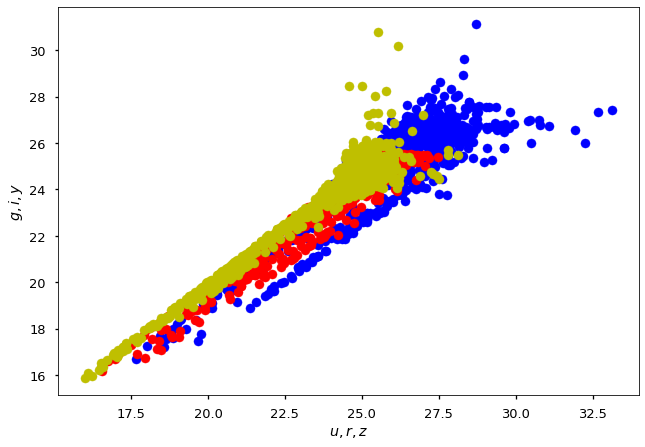

In [18]:
#plt.scatter(np.array(zMag) - (iMag),iMag)
plt.scatter(uMag, gMag, c='b')
plt.scatter(rMag, iMag, c='r')
plt.scatter(zMag, yMag, c='y')
#plt.ylim([-1,4])
#plt.xlim([-1,4])
#plt.xlabel('$g-r$')
#plt.ylabel('$r-i$')
plt.xlabel('$u, r, z$')
plt.ylabel('$g, i, y$')

Text(0, 0.5, '$dec (rad)$')

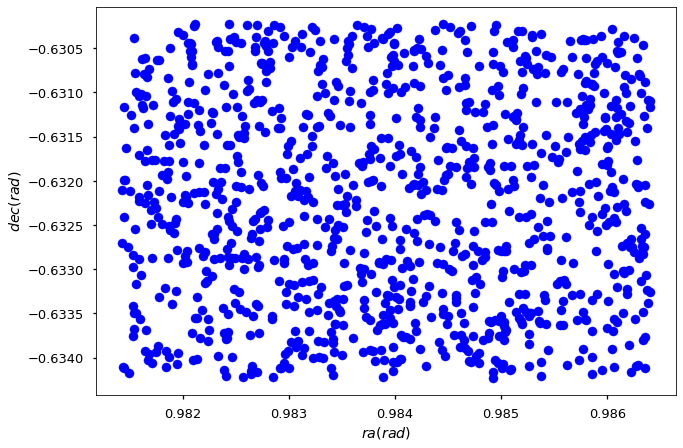

In [19]:
#plt.scatter(np.array(zMag) - (iMag),iMag)
plt.scatter(yPtSources['coord_ra'], yPtSources['coord_dec'], c='b')
plt.xlabel('$ra (rad)$')
plt.ylabel('$dec (rad)$')

In [20]:
starArray = [uPtSources['coord_ra'], uPtSources['coord_dec'], uMag]

In [21]:
starArray2 = np.array(starArray)

Text(0, 0.5, '$dec (rad)$')

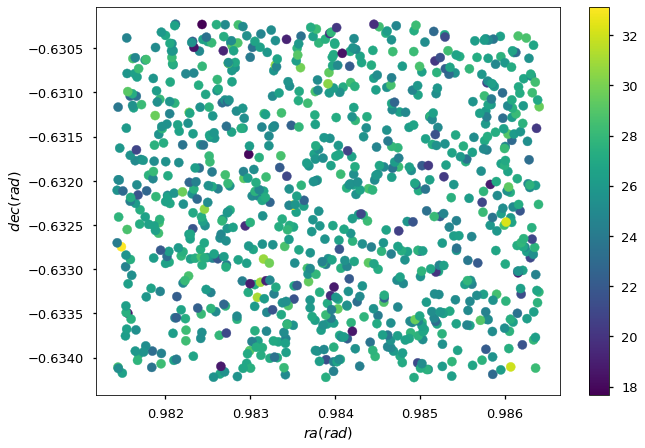

In [22]:
#plt.scatter(np.array(zMag) - (iMag),iMag)
plt.scatter(starArray2[0], starArray2[1], c=starArray2[2])
plt.colorbar()
plt.xlabel('$ra (rad)$')
plt.ylabel('$dec (rad)$')
#plt.ylim([-0.6335,-0.6330])
#plt.xlim([0.9828, 0.9834])


In [23]:
starArray3 = np.where(starArray2[2] > 28.)

In [24]:
len(starArray3)

1

In [25]:
starArray3

(array([   6,   12,   17,   55,   63,   66,   76,   77,   80,   84,   85,
         109,  112,  125,  126,  127,  141,  143,  146,  150,  186,  187,
         191,  196,  198,  204,  219,  223,  238,  240,  246,  257,  258,
         263,  268,  291,  316,  341,  368,  369,  377,  380,  395,  400,
         413,  453,  454,  458,  485,  509,  528,  540,  543,  565,  579,
         591,  599,  603,  632,  644,  662,  692,  694,  698,  701,  725,
         731,  740,  755,  764,  778,  799,  809,  813,  830,  832,  836,
         839,  843,  856,  862,  870,  886,  891,  905,  906,  907,  909,
         925,  930,  934,  937,  946,  954,  956,  962,  969,  972,  979,
         983,  985,  995, 1007, 1023, 1029, 1035, 1036, 1041, 1043, 1050]),)

In [26]:
import bokeh
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, Range1d, HoverTool, Selection
from bokeh.plotting import figure, output_file

In [27]:
# Need this line to display bokeh plots inline in the notebook
output_notebook()

Loading BokehJS ...